## COMP-4448

#### Christopher Kramer
#### 2021-03-09
## Mall Market Segmentation via KNN

In [57]:
import sklearn # PCA, clustering
import pandas as pd # used as ETE data structure, EDA/profiling
import seaborn as sns # used for data import, 2d plots
import matplotlib.pyplot as plt # used for 3d plots
import matplotlib as mpl # used for 3d plots
import numpy as np # used for typing
from dataclasses import dataclass # used for profiling
from pandas_profiling import ProfileReport

import warnings

from typing import NoReturn, Optional, Union # typing
from mpl_toolkits.mplot3d import Axes3D # used for 3d plots
from sklearn.compose import make_column_transformer

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

sns.set_style('whitegrid')

Question 1

•	Data cleaning where necessary

In [58]:
df = pd.read_csv('Mall_Customers.csv').drop(['CustomerID'], 1)

In [59]:
df.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


In [60]:
df.isna().sum()

Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [61]:
df.describe()

,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


•	Scale the data using an appropriate scaler



In [62]:
ct = make_column_transformer((MinMaxScaler(), ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']), 
                             (OneHotEncoder(), ['Gender']))

In [63]:
X = pd.DataFrame(ct.fit_transform(df), columns = ['age', 'income', 'spendscore', 'gender_f', 'gender_m'])

In [64]:
X

,age,income,spendscore,gender_f,gender_m
0,0.019231,0.000000,0.387755,0.0,1.0
1,0.057692,0.000000,0.816327,0.0,1.0
2,0.038462,0.008197,0.051020,1.0,0.0
3,0.096154,0.008197,0.775510,1.0,0.0
4,0.250000,0.016393,0.397959,1.0,0.0
...,...,...,...,...,...
195,0.326923,0.860656,0.795918,1.0,0.0
196,0.519231,0.909836,0.275510,1.0,0.0
197,0.269231,0.909836,0.744898,0.0,1.0
198,0.269231,1.000000,0.173469,0.0,1.0



•	Conduct a principal component analysis 


In [65]:
from sklearn.decomposition import PCA

In [66]:
pcask = list(map(lambda x: PCA(n_components=x, random_state=42), [2, 3, .95]))

In [67]:
list(map(lambda x: x.fit(X), pcask))

[PCA(n_components=2, random_state=42),
 PCA(n_components=3, random_state=42),
 PCA(n_components=0.95, random_state=42)]

2 comps:

In [68]:
pcask[0].explained_variance_

array([0.49605563, 0.09341752])

In [69]:
sum(pcask[0].explained_variance_)

0.5894731518544857

3 comps:

In [70]:
pcask[1].explained_variance_

array([0.49605563, 0.09341752, 0.04760125])

In [71]:
sum(pcask[1].explained_variance_)

0.637074404376449

.95 variance:

In [72]:
len(pcask[2].components_)

4

In [73]:
len(X.columns)

5

In [74]:
pd.DataFrame(pcask[2].components_,columns=X.columns,index = [f'PC-{x+1}' for x in range(0, len(pcask[2].components_))])

,age,income,spendscore,gender_f,gender_m
PC-1,0.028551,0.018908,-0.026760,-0.706439,0.706439
PC-2,0.726813,-0.026264,-0.685245,0.027315,-0.027315
PC-3,-0.683757,0.058010,-0.727399,0.000736,-0.000736
PC-4,0.058343,0.997791,0.024760,0.014063,-0.014063


The data must retain 4 components to achieve .95 variance explainability. At 2 and 3 components, 58% and 63% explainability is achieved, respectively.


•	Construct a dendrogram using agglomerative clustering to see how many clusters will be optimal to specify in the kmeans clustering. 



In [75]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [76]:
Z = linkage(X, 'ward')

In [77]:
Z_table = pd.DataFrame(Z, columns=['merge_index1', 'merge_index2', 'distance', 'sample_count'])
Z_table

,merge_index1,merge_index2,distance,sample_count
0,129.0,131.0,0.019231,2.0
1,65.0,68.0,0.019231,2.0
2,3.0,5.0,0.023262,2.0
3,60.0,70.0,0.026623,2.0
4,114.0,115.0,0.028041,2.0
...,...,...,...,...
194,376.0,390.0,2.145281,59.0
195,387.0,389.0,2.531713,52.0
196,393.0,394.0,3.721188,112.0
197,392.0,395.0,3.803026,88.0


### Dendrogram

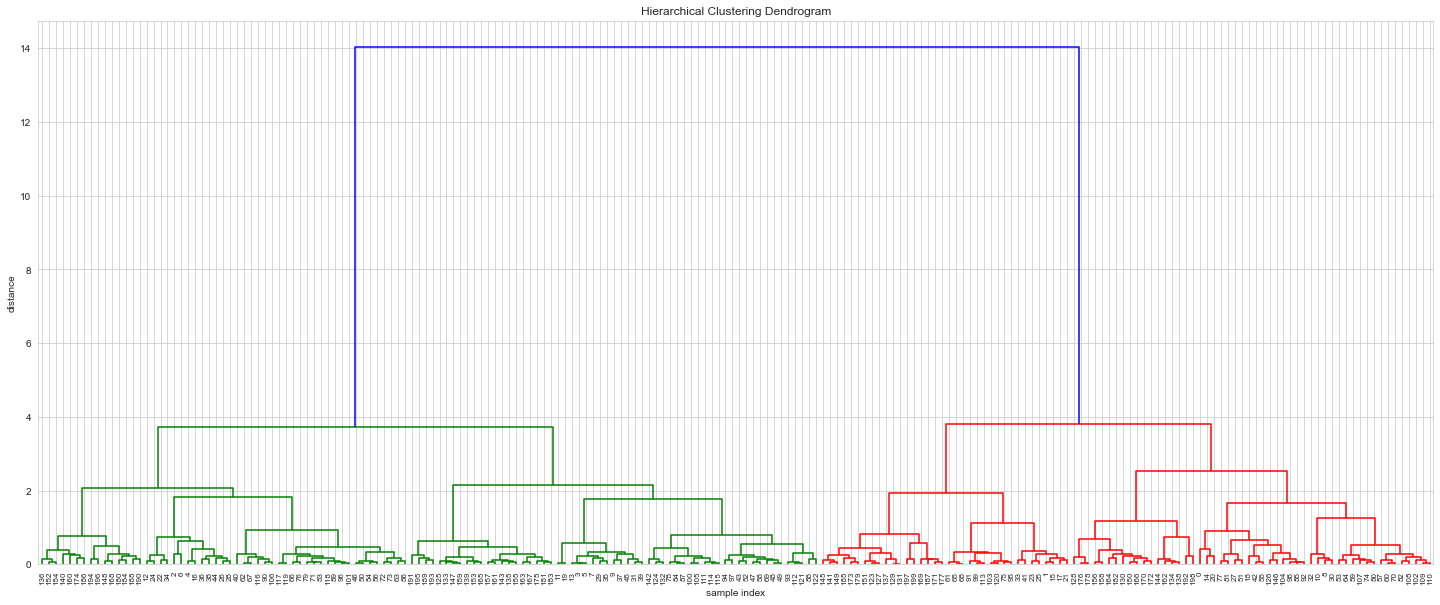

In [78]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

Setting a cutoff at d=3 appears reasonable, leaving 4 clusters. Alterantively, 2 clusters could be set at d>=4.


•	Implement a kmeans clustering to find the clusters in the data


In [23]:
from sklearn.cluster import KMeans

In [79]:
km = KMeans(n_clusters=4, random_state=42)

In [80]:
km.fit(X)

KMeans(n_clusters=4, random_state=42)


•	Predict the clusters


In [81]:
dat = X.copy()

In [82]:
dat['y'] = km.predict(X)

In [83]:
dat['y']

0      2
1      2
2      3
3      1
4      1
      ..
195    1
196    3
197    2
198    0
199    2
Name: y, Length: 200, dtype: int32



•	Visualize the clusters


Using gender, age, and spend_score to visualize.

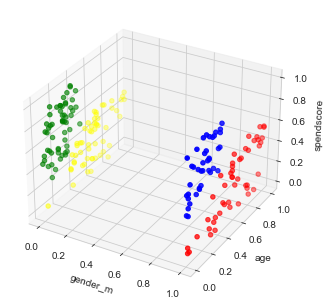

In [84]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(xs = dat['gender_m'], ys = dat['age'], zs = dat['spendscore'], c=dat['y'], cmap=mpl.colors.ListedColormap(['red', 'green', 'blue', 'yellow']))
ax.set_xlabel('gender_m')
ax.set_ylabel('age')
ax.set_zlabel('spendscore')
plt.show()


•	Also use a loop and a plot to tune the number of clusters. Does the number of clusters obtain parallel the number of clusters obtained using the dendrogram?



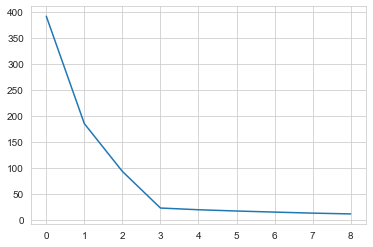

In [85]:
n_clusters = list(range(1, 10))
within_cluster_var = []
for i in n_clusters:
    clu = KMeans(n_clusters=i)
    clu = clu.fit(dat)
    within_cluster_var.append(clu.inertia_)

plt.plot(within_cluster_var)

This method appears to suggest 3 clusters.


•	Add the cluster values to your original dataset to be the labels 


See above


•	Using tools in sklearn, run a logistic regression on the original dataset with new labels to classify cases into the clusters or labels. 


In [86]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [87]:
X_train, X_test, y_train, y_test = train_test_split(dat[dat.columns[~dat.columns.isin(['y'])]], dat['y'], test_size=.3, random_state=42)

In [88]:
clf = LogisticRegression()

In [89]:
clf.fit(X_train, y_train)

LogisticRegression()

In [90]:
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        18
           2       1.00      1.00      1.00         9
           3       1.00      1.00      1.00        18

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



In [91]:
accuracy_score(y_test, clf.predict(X_test), normalize=True)

1.0



•	Tune the cutoff value, c, of the logistic regression constructor in sklearn and plot the error rates and the corresponding settings of c. note that the cutoff c ranges from 0 to 1.


In [92]:
from sklearn import metrics

In [93]:
cs = np.linspace(0, 1, 101)[1:]
accs = []
preds = clf.predict_proba(X_test)
accs = list(map(lambda c: accuracy_score(y_test, np.where(preds[:, 1]>c, 1, 0), normalize=True), cs))

<AxesSubplot:>

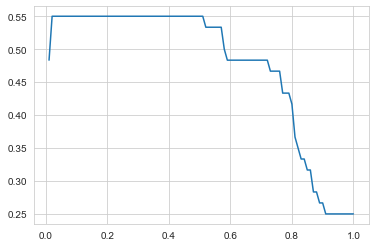

In [94]:
sns.lineplot(x=cs, y=accs)


•	Use the optimal cut off to compute the accuracy of your logistic regression.


In [95]:
print(f'Optimal accuracy: {accs[np.argmax(accs)]} at c = {cs[np.argmax(accs)]}')

Optimal accuracy: 0.55 at c = 0.02




•	Do you think the clustering algorithm found good clusters that can be used for classification? 


Yes, the model seems to make some distinction between high-spend score males, low-spend score males, high-spend score females, and low-spend score females.

In [96]:
dat[dat['y'] == 0].describe()

,age,income,spendscore,gender_f,gender_m,y
count,48.000000,48.000000,48.000000,48.0,48.0,48.0
mean,0.604567,0.388661,0.287840,0.0,1.0,0.0
std,0.269783,0.202429,0.196595,0.0,0.0,0.0
min,0.019231,0.032787,0.000000,0.0,1.0,0.0
25%,0.423077,0.254098,0.109694,0.0,1.0,0.0
50%,0.586538,0.389344,0.316327,0.0,1.0,0.0
75%,0.793269,0.516393,0.461735,0.0,1.0,0.0
max,1.000000,1.000000,0.602041,0.0,1.0,0.0


In [97]:
dat[dat['y'] == 1].describe()

,age,income,spendscore,gender_f,gender_m,y
count,57.000000,57.000000,57.000000,57.0,57.0,57.0
mean,0.200742,0.366120,0.680451,1.0,0.0,1.0
std,0.105645,0.216916,0.190941,0.0,0.0,0.0
min,0.000000,0.008197,0.285714,1.0,0.0,1.0
25%,0.096154,0.196721,0.510204,1.0,0.0,1.0
50%,0.230769,0.385246,0.734694,1.0,0.0,1.0
75%,0.269231,0.516393,0.836735,1.0,0.0,1.0
max,0.423077,0.860656,1.000000,1.0,0.0,1.0


In [98]:
dat[dat['y'] == 2].describe()

,age,income,spendscore,gender_f,gender_m,y
count,40.000000,40.000000,40.000000,40.0,40.0,40.0
mean,0.197115,0.385246,0.721173,0.0,1.0,2.0
std,0.134139,0.238670,0.170690,0.0,0.0,0.0
min,0.000000,0.000000,0.387755,0.0,1.0,2.0
25%,0.072115,0.213115,0.584184,0.0,1.0,2.0
50%,0.192308,0.393443,0.734694,0.0,1.0,2.0
75%,0.293269,0.516393,0.892857,0.0,1.0,2.0
max,0.423077,1.000000,0.979592,0.0,1.0,2.0


In [99]:
dat[dat['y'] == 3].describe()

,age,income,spendscore,gender_f,gender_m,y
count,55.000000,55.000000,55.000000,55.0,55.0,55.0
mean,0.579021,0.359165,0.344712,1.0,0.0,3.0
std,0.189172,0.211245,0.168011,0.0,0.0,0.0
min,0.038462,0.008197,0.040816,1.0,0.0,3.0
25%,0.451923,0.213115,0.204082,1.0,0.0,3.0
50%,0.596154,0.344262,0.387755,1.0,0.0,3.0
75%,0.692308,0.483607,0.484694,1.0,0.0,3.0
max,0.961538,0.909836,0.591837,1.0,0.0,3.0



•	Try if you can interpret or describe what the clusters represent based on the pattern of values in the data set and the cluster. For example, if the data was only age and income, maybe clusters one is young and richer, cluster two may be rich seniors and cluster three are poor youths. Your visualization can also help with this interpretation. 

1. Females with a high spendscore, and lower age
2. Males with a low spendscore and higher age
3. Males with a high spendscore and lower age
4. Females with a lower spendscore and higher age